#**Proyecto Análisis de Video**

Integrantes: Matías Bozo y Jorge Morales

Se instalan las bibliotecas necesarias para trabajar con videos y modelos en PyTorch. Además, se utiliza `IPython.display` para limpiar la salida de la celda, eliminando mensajes innecesarios generados durante las instalaciones.

In [1]:
!pip install pytorchvideo   # Biblioteca para tareas de video con PyTorch
!pip install torchsummary   # Bibiloteca para resumir arquitecturas
!pip install kaggle         # Biblioteca para interactuar con la API de Kaggle

from IPython import display
display.clear_output()

Se utiliza la funcionalidad de Google Colab para subir archivos desde el sistema local al entorno de trabajo. Esto es necesario para subir el archivo `kaggle.json`, que contiene las credenciales de la API de Kaggle, que permite descargar datasets directamente desde Kaggle.

In [2]:
from google.colab import files

# Subir el archivo kaggle.json desde el sistema local al entorno de Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matasbozopizarro","key":"ecd5b25ccfa3da91e256871c16d8c92a"}'}

Se configuran las credenciales de la API de Kaggle. Se crea el directorio necesario para almacenar el archivo kaggle.json, se mueve el archivo a ese directorio y se ajustan los permisos para garantizar la seguridad.

In [3]:
# Crear un directorio para Kaggle
!mkdir -p ~/.kaggle

# Mover el archivo kaggle.json subido al directorio de Kaggle
!cp kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo para mayor seguridad
!chmod 600 ~/.kaggle/kaggle.json

Se descarga el dataset desde Kaggle utilizando la API de Kaggle. El parámetro `-d` indica el dataset a descargar, en este caso, **"real-life-violence-situations-dataset"**.


In [4]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
 99% 3.56G/3.58G [00:45<00:00, 117MB/s]
100% 3.58G/3.58G [00:45<00:00, 84.7MB/s]


Se descomprime el archivo descargado desde Kaggle (en formato .zip) en un directorio específico. Se define la ruta del archivo comprimido, se especifica un directorio de extracción y se descomprimen los contenidos.

In [5]:
import zipfile              # Biblioteca para manejar archivos comprimidos ZIP
import os                   # Biblioteca para manejar operaciones de sistema de archivos

# Especificar la ruta del archivo ZIP descargado
zip_file_path = '/content/real-life-violence-situations-dataset.zip'

# Especificar la ruta donde se descomprimirá el archivo
extraction_path = '/content/real-life-violence-situations-dataset/'

# Crear el directorio de extracción si no existe
os.makedirs(extraction_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Listar los archivos en el directorio de extracción para verificar
extracted_files = os.listdir(extraction_path)
print("Archivos extraídos:", extracted_files)

Archivos extraídos: ['real life violence situations', 'Real Life Violence Dataset']


In [6]:
from google.colab import drive  # Importar la funcionalidad para trabajar con Google Drive

# Montar Google Drive en el entorno de trabajo de Colab
drive.mount('/content/drive')

Mounted at /content/drive


 Se importan las bibliotecas necesarias para el procesamiento, manipulación de datos, división de conjuntos de datos y uso de PyTorch.

In [7]:
import torch                                            # Biblioteca principal para el cálculo numérico y aprendizaje profundo
import torch.nn as nn                                   # Módulo de PyTorch para construir redes neuronales
import torch.nn.functional as F                         # Funciones de activación y otras operaciones matemáticas para redes neuronales
import torch.optim as optim                             # Herramientas para optimización de modelos (SGD, Adam, etc.)
import torchvision                                      # Extensión de PyTorch para tareas relacionadas con imágenes y videos
import torchvision.transforms as transforms             # Herramientas para aplicar transformaciones a los datos (normalización, rotación, etc.)
from torch.utils.data import Dataset, DataLoader        # Clases para crear y cargar conjuntos de datos personalizados
from torchsummary import summary                        # Resumen detallado de arquitecturas de modelos de redes neuronales

import cv2                                              # Biblioteca para procesamiento de imágenes y videos
import numpy as np                                      # Biblioteca para cálculos numéricos con arreglos multidimensionales
import matplotlib.pyplot as plt                         # Biblioteca para crear gráficos y visualizaciones
import shutil                                           # Manejo de operaciones con archivos y directorios (copiar, mover, eliminar)
import copy                                             # Herramientas para realizar copias profundas y superficiales de objetos en Python

from sklearn.model_selection import train_test_split    # Herramienta para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import (roc_curve, roc_auc_score,  # Métricas para evaluar la curva ROC y el AUC
                             classification_report,     # Generar reportes detallados de clasificación
                             confusion_matrix,          # Calcular la matriz de confusión
                             ConfusionMatrixDisplay)    # Visualizar la matriz de confusión

Se definen las rutas para el dataset original y los datos preprocesados, así como parámetros importantes para la manipulación de videos y las clases que serán usadas en el modelo.

In [8]:
# Definir ruta del dataset original descomprimido
ds_input_path = '/content/real-life-violence-situations-dataset/Real Life Violence Dataset'

# Definir ruta donde se almacenarán los datos preprocesados
ds_preprocessed_path = '/content/processed-dataset/'

# Definir rutas para los conjuntos de datos de entrenamiento, validación y prueba
train_path = os.path.join(ds_preprocessed_path, 'train')
os.makedirs(train_path, exist_ok=True)

val_path = os.path.join(ds_preprocessed_path, 'val')
os.makedirs(val_path, exist_ok=True)

test_path = os.path.join(ds_preprocessed_path, 'test')
os.makedirs(test_path, exist_ok=True)

# Definir parámetros relacionados con los videos
NUM_FRAMES = 16  # Número de frames que se procesarán por video
FRAME_W = 256    # Ancho de cada frame (dimensiones de la imagen)
FRAME_H = 256    # Alto de cada frame (dimensiones de la imagen)

# Definir clases objetivo del dataset
CLASS_NAMES = ['Violence', 'NonViolence']  # Nombres de las clases de los datos

Para inspeccionar los datos, se obtiene información básica de los videos, como la resolución y el número de frames de cada video.

In [9]:
# Recorrer el directorio de entrada
for root, dirs, files in os.walk(ds_input_path):
    for filename in files:
        # Obtener la ruta completa del archivo
        file_path = os.path.join(root, filename)

        # Procesar solo los archivos con extensión .mp4
        if file_path.endswith('.mp4'):
            # Crear un objeto VideoCapture para leer el video
            cap = cv2.VideoCapture(file_path)

            # Obtener la resolución (ancho y alto) y el número de frames para el video
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Imprimir información básica del video
            print(f"Video: {filename} | Número de frames: {num_frames} - Resolución: {width} x {height}")

            # Liberar el objeto VideoCapture
            cap.release()

Video: V_88.mp4 | Número de frames: 138 - Resolución: 640 x 360
Video: V_789.mp4 | Número de frames: 11272 - Resolución: 1280 x 720
Video: V_401.mp4 | Número de frames: 126 - Resolución: 360 x 360
Video: V_840.mp4 | Número de frames: 150 - Resolución: 834 x 714
Video: V_999.mp4 | Número de frames: 150 - Resolución: 260 x 360
Video: V_330.mp4 | Número de frames: 129 - Resolución: 1280 x 628
Video: V_686.mp4 | Número de frames: 125 - Resolución: 224 x 224
Video: V_698.mp4 | Número de frames: 125 - Resolución: 224 x 224
Video: V_386.mp4 | Número de frames: 153 - Resolución: 1280 x 720
Video: V_469.mp4 | Número de frames: 147 - Resolución: 396 x 720
Video: V_990.mp4 | Número de frames: 150 - Resolución: 292 x 360
Video: V_415.mp4 | Número de frames: 96 - Resolución: 640 x 352
Video: V_209.mp4 | Número de frames: 171 - Resolución: 402 x 720
Video: V_331.mp4 | Número de frames: 176 - Resolución: 368 x 656
Video: V_201.mp4 | Número de frames: 168 - Resolución: 230 x 360
Video: V_114.mp4 | Núm

Se define función encargada de preprocesar un video, guardándolo como archivo `.npy`.


In [10]:
def preprocess_video(video_path, output_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    # Crear un objeto VideoCapture para leer el video
    cap = cv2.VideoCapture(video_path)
    frames = []  # Lista para almacenar los frames del video

    # Leer los frames del video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Salir del bucle si no hay más frames

        # Convertir el frame de BGR a RGB y redimensionarlo
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, resize)

        # Añadir el frame procesado a la lista
        frames.append(frame)

    # Liberar el objeto VideoCapture
    cap.release()

    # Convertir los frames a un array de NumPy
    frames = np.array(frames)

    # Muestrear los frames
    if len(frames) > num_frames:
        # Seleccionar un número fijo de frames de manera uniforme
        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        sampled_frames = frames[indices]
    elif len(frames) < num_frames:
        # Rellenar con frames vacíos si hay menos de los necesarios
        padding = np.zeros((num_frames - len(frames), *resize, 3))
        sampled_frames = np.concatenate((frames, padding), axis=0)
    else:
        sampled_frames = frames  # Usar los frames directamente si tienen la cantidad exacta

    # Guardar los frames preprocesados en un archivo .npy
    np.save(output_path, sampled_frames)

Se define una función que realiza el preprocesamiento de videos y divide los datos en conjuntos de entrenamiento, validación y prueba.

In [12]:
def split_and_preprocess_videos(input_folder, train_dir, val_dir, test_dir, frame_size):
    for class_name in CLASS_NAMES:
        class_folder = os.path.join(input_folder, class_name)

        # Obtener todos los archivos de video en la carpeta de la clase
        videos = [f for f in os.listdir(class_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

        # Dividir los videos en conjuntos de entrenamiento, validación y prueba
        train_videos, temp_videos = train_test_split(videos, test_size=0.2, random_state=42)
        val_videos, test_videos = train_test_split(temp_videos, test_size=0.5, random_state=42)

        # Crear un diccionario para los conjuntos divididos
        splits = {'train': train_videos, 'val': val_videos, 'test': test_videos}

        # Iterar sobre los conjuntos divididos
        for split in splits:
            # Definir la carpeta de salida correspondiente
            split_folder = os.path.join(train_dir if split == 'train' else val_dir if split == 'val' else test_dir, class_name)
            os.makedirs(split_folder, exist_ok=True)  # Crear la carpeta si no existe

            # Procesar cada video y guardarlo en el formato preprocesado
            for video in splits[split]:
                video_path = os.path.join(class_folder, video)  # Ruta completa del video original
                output_path = os.path.join(split_folder, video.replace('.mp4', '.npy'))  # Ruta para guardar el archivo preprocesado
                preprocess_video(video_path, output_path, NUM_FRAMES, frame_size)  # Preprocesar el video
                print(f"Archivo {video} procesado y guardado en {split_folder}")  # Mensaje de confirmación

Se instancia la función `split_and_preprocess_videos`.

In [13]:
# Procesar y dividir los videos del conjunto de datos real-life-violence-dataset
split_and_preprocess_videos(input_folder= ds_input_path, train_dir= train_path, val_dir= val_path, test_dir= test_path, frame_size = (FRAME_W, FRAME_H))

Archivo V_175.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_356.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_157.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_570.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_621.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_994.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_236.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_29.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_624.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_148.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_265.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_202.mp4 procesado y guardado en /content/processed-dataset/train/Vi

Se configura el dispositivo de cómputo (CPU o GPU) para el preprocesamiento de datos y entrenamiento del modelo. Además, se establecen los parámetros clave para el preprocesamiento de los datos.

In [14]:
# Configurar del dispositivo (CPU o GPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo configurado: {DEVICE}')

# Definir parámetros clave para el preprocesamiento de datos
BATCH_SIZE = 4     # Tamaño del lote para el entrenamiento
NUM_EPOCHS = 5     # Número de épocas de entrenamiento
NUM_FRAMES = 16    # Número de frames por video a procesar
FRAME_W = 256      # Ancho de cada frame
FRAME_H = 256      # Alto de cada frame

Dispositivo configurado: cuda


Se define una función para contar el número de muestras de cada clase (`Violence`, `NonViolence`) dentro de los subconjuntos (`train`, `val`, `test`).

In [19]:
def count_samples(data_dir):
    counts = {}  # Definir diccionario para almacenar los conteos
    for subset in ['train', 'val', 'test']:  # Iterar sobre los subconjuntos de datos
        subset_path = os.path.join(data_dir, subset)
        counts[subset] = {}
        for category in ['Violence', 'NonViolence']:  # Iterar sobre las categorías
            category_path = os.path.join(subset_path, category)
            num_samples = len(os.listdir(category_path))
            counts[subset][category] = num_samples
    return counts

Se instancia la función `count_samples` y se muestra por consola el número de muestras por subconjunto.

In [20]:
sample_counts = count_samples(ds_preprocessed_path)

for subset, categories in sample_counts.items():
    print(f"{subset} set:")
    for category, count in categories.items():
        print(f"  {category}: {count} samples")

train set:
  Violence: 800 samples
  NonViolence: 800 samples
val set:
  Violence: 100 samples
  NonViolence: 100 samples
test set:
  Violence: 100 samples
  NonViolence: 100 samples


Se define la clase `VideoDataset`, que extiende la clase base `Dataset` de PyTorch y está diseñada para manejar datasets de videos preprocesados almacenados como archivos `.npy`.

In [21]:
class VideoDataset(Dataset):
    # Definir constructor de la clase VideoDataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Violence', 'NonViolence']
        self.frame_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for frame_file in os.listdir(class_dir):
                frame_path = os.path.join(class_dir, frame_file)
                self.frame_paths.append(frame_path)
                self.labels.append(label)
    # Definir función que devuelve la cantidad total de elementos en el dataset
    def __len__(self):
        return len(self.frame_paths)
    # Definir función que devuelve los frames y la etiqueta para un índice específico
    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        label = self.labels[idx]
        frames = np.load(frame_path)
        if self.transform:
            frames = self.transform(frames)
        return frames, label

Se define la clase `ToTensor`, que convierte un conjunto de frames (en formato NumPy) a un tensor de PyTorch, con formato adecuado para los modelos X3D.

In [22]:
class ToTensor(object):
    # Convertir un conjunto de frames de NumPy a un tensor de PyTorch y normaliza los valores
    def __call__(self, sample):
        frames = sample
        # Cambiar el orden de los ejes (T, H, W, C) a (C, T, H, W)
        frames = frames.transpose((3, 0, 1, 2))
        # Convertir de NumPy a tensor de PyTorch
        frames = torch.from_numpy(frames).float()
        # Normalizar los valores de los píxeles al rango [0, 1]
        frames = frames / 255.0
        return frames

A continuación:
* Se construyen las rutas para los datos de entrenamiento, validación y prueba.
* Se definen las transformaciones de datos.
* Se crean los datasets correspondientes utilizando la clase `VideoDataset`.
* Se generan los `DataLoaders` para procesar los datos en lotes durante el entrenamiento y la evaluación.

In [23]:
# Construir correctamente las rutas para train, val y test
train_dir = os.path.join(ds_preprocessed_path, 'train')
val_dir = os.path.join(ds_preprocessed_path, 'val')
test_dir = os.path.join(ds_preprocessed_path, 'test')

# Transformar datos
data_transforms = {
    'train': transforms.Compose([ToTensor()]),
    'val': transforms.Compose([ToTensor()]),
    'test': transforms.Compose([ToTensor()]),
}

# Crear datasets para train, val y test
train_dataset = VideoDataset(root_dir=train_dir, transform=data_transforms['train'])
val_dataset = VideoDataset(root_dir=val_dir, transform=data_transforms['val'])
test_dataset = VideoDataset(root_dir=test_dir, transform=data_transforms['test'])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Se verifica que los `DataLoaders` estén funcionando correctamente al iterar sobre un lote del conjunto de entrenamiento (`train_loader`).

In [24]:
# Comprobar el funcionamiento de los DataLoaders
for i, (videos, labels) in enumerate(train_loader):
        print(videos.shape, labels.shape)
        break

torch.Size([4, 3, 16, 256, 256]) torch.Size([4])


Se define una función que permite personalizar el modelo preentrenado X3D de PyTorchVideo para realizar fine-tuning en una tarea de clasificación con un número específico de clases y la variante de X3D deseada. Reemplaza la capa final del modelo con una capa totalmente conectada (`Linear`) adaptada al número de clases objetivo (2).

In [25]:
def custom_X3D(model_name, num_classes):
    # Cargar el modelo preentrenado
    model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

    # Configurar la última capa para el número de clases deseado
    input_size = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(in_features=input_size, out_features=num_classes)

    return model

Se define una función que implementa el proceso de entrenamiento para un modelo de PyTorch. Toma un lote de datos, realiza un pase hacia adelante, calcula la pérdida, realiza un pase hacia atrás (backpropagation), y actualiza los pesos del modelo utilizando un optimizador.

In [26]:
# Entrena el modelo durante una época.
def train(model, loader, optimizer, criterion):
    model.train()  # Poner el modelo en modo de entrenamiento
    running_loss = 0.0  # Acumular la pérdida total
    correct = 0         # Contar predicciones correctas
    total = 0           # Contar el número total de muestras

    for videos, labels in loader:
        # Mover los datos al dispositivo configurado (CPU o GPU)
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)

        # Reiniciar los gradientes del optimizador
        optimizer.zero_grad()

        # Pase hacia adelante: calcular las salidas del modelo
        outputs = model(videos)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Pase hacia atrás: calcular los gradientes
        loss.backward()

        # Actualizar los pesos del modelo
        optimizer.step()

        # Acumular la pérdida total
        running_loss += loss.item()

        # Obtener las predicciones del modelo
        _, predicted = outputs.max(1)

        # Actualizar el total de muestras y las correctas
        total += labels.size(0)  # Sumar el tamaño del lote
        correct += predicted.eq(labels).sum().item()  # Sumar predicciones correctas

    # Calcular la pérdida promedio y la exactitud
    loss = running_loss / len(loader)  # Promedio de pérdida
    accuracy = correct / total         # Exactitud

    return loss, accuracy

Se define una función que evalúa el modelo en un conjunto de datos de validación o prueba. Calcula la pérdida y la precisión, deshabilitando el cálculo de gradientes para reducir el uso de memoria y acelerar el proceso.

In [27]:
# Evalúa el modelo en un conjunto de datos
def evaluate(model, loader, criterion):
    model.eval()  # Poner el modelo en modo de evaluación
    correct = 0         # Contador de predicciones correctas
    total = 0           # Contador de muestras totales
    running_loss = 0.0  # Acumulador de pérdida

    # Deshabilitar el cálculo de gradientes (optimización)
    with torch.no_grad():
        for inputs, labels in loader:
            # Mover los datos al dispositivo configurado (CPU o GPU)
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Pase hacia adelante: calcular las salidas del modelo
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Obtener las predicciones del modelo
            _, predicted = torch.max(outputs.data, 1)

            # Actualizar los contadores
            total += labels.size(0)  # Sumar el tamaño del lote
            correct += (predicted == labels).sum().item()  # Contar predicciones correctas

    # Calcular la pérdida promedio y la precisión
    loss = running_loss / len(loader)  # Promedio de pérdida
    acc = correct / total              # Precisión

    return loss, acc

Se configuran los modelos X3D, sus respectivos optimizadores y la función de pérdida para el entrenamiento.

In [28]:
# Número de clases para la clasificación
num_classes = 2 # Violence - NonViolence

# Configurar los modelos X3D personalizados y moverlos al dispositivo
model_xs = custom_X3D('x3d_xs', num_classes).to(DEVICE)
model_s = custom_X3D('x3d_s', num_classes).to(DEVICE)
model_m = custom_X3D('x3d_m', num_classes).to(DEVICE)

# Configurar el optimizador Adam con una tasa de aprendizaje inicial
optimizer_xs = torch.optim.Adam(model_xs.parameters(), lr=0.001)
optimizer_s = torch.optim.Adam(model_s.parameters(), lr=0.001)
optimizer_m = torch.optim.Adam(model_m.parameters(), lr=0.001)

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_XS.pyth" to /root/.cache/torch/hub/checkpoints/X3D_XS.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 88.4MB/s]
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_S.pyth" to /root/.cache/torch/hub/checkpoints/X3D_S.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 144MB/s]
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_M.pyth" to /root/.cache/torch/hub/checkpoints/X3D_M.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 152MB/s] 


 Se utiliza la función summary() para mostrar la estructura de cada modelo X3D, los parámetros aprendibles y las dimensiones de las entradas y salidas en cada capa de los modelos.

In [29]:
summary(model_xs, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)
summary(model_s, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)
summary(model_m, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 24, 16, 128, 128]             648
            Conv3d-2     [-1, 24, 16, 128, 128]             120
       Conv2plus1d-3     [-1, 24, 16, 128, 128]               0
       BatchNorm3d-4     [-1, 24, 16, 128, 128]              48
              ReLU-5     [-1, 24, 16, 128, 128]               0
   ResNetBasicStem-6     [-1, 24, 16, 128, 128]               0
            Conv3d-7       [-1, 24, 16, 64, 64]             576
            Conv3d-8     [-1, 54, 16, 128, 128]           1,296
       BatchNorm3d-9     [-1, 54, 16, 128, 128]             108
             ReLU-10     [-1, 54, 16, 128, 128]               0
           Conv3d-11       [-1, 54, 16, 64, 64]           1,458
      BatchNorm3d-12       [-1, 54, 16, 64, 64]             108
           Conv3d-13           [-1, 8, 1, 1, 1]             440
             ReLU-14           [-1, 8, 

 Se implementa el bucle de entrenamiento y validación de los modelos X3D. Adapta automáticamente el modelo para usar múltiples GPUs si están disponibles, y guarda el mejor modelo basado en la exactitud en el conjunto de validación.

In [30]:
# Si hay múltiples GPUs, usar DataParallel para dividir el modelo
models = {"xs": model_xs, "s": model_s, "m": model_m}
optimizers = {"xs": optimizer_xs, "s": optimizer_s, "m": optimizer_m}
for key in models:
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for model {key}!")
        models[key] = torch.nn.DataParallel(models[key])
    models[key] = models[key].to(DEVICE)

# Inicializar listas para registrar métricas por modelo
metrics = {
    "xs": {"train_losses": [], "train_accuracies": [],"test_loss": [], "test_acc": [], "val_losses": [], "val_accuracies": [], "best_model": None, "best_acc": 0},
    "s": {"train_losses": [], "train_accuracies": [],"test_loss": [], "test_acc": [], "val_losses": [], "val_accuracies": [], "best_model": None, "best_acc": 0},
    "m": {"train_losses": [], "train_accuracies": [],"test_loss": [], "test_acc": [], "val_losses": [], "val_accuracies": [], "best_model": None, "best_acc": 0},
}

# Bucle de entrenamiento
for epoch in range(NUM_EPOCHS):
    for key in models:
        print(f"\n--- Época {epoch + 1}/{NUM_EPOCHS} para el modelo {key} ---")

        # Entrenar el modelo en el conjunto de entrenamiento
        train_loss, train_acc = train(models[key], train_loader, optimizers[key], criterion)

        # Evaluar el modelo en el conjunto de validación
        val_loss, val_acc = evaluate(models[key], val_loader, criterion)

        # Guardar las pérdidas y exactitudes para análisis posterior
        metrics[key]["train_losses"].append(train_loss)
        metrics[key]["train_accuracies"].append(train_acc)
        metrics[key]["val_losses"].append(val_loss)
        metrics[key]["val_accuracies"].append(val_acc)

        # Si la precisión en validación mejora, actualizar el mejor modelo
        if val_acc > metrics[key]["best_acc"]:
            metrics[key]["best_acc"] = val_acc
            metrics[key]["best_model"] = copy.deepcopy(models[key])

        # Imprimir el progreso de entrenamiento y validación
        print(f"Modelo {key} - Época {epoch + 1}/{NUM_EPOCHS}: "
              f"Pérdida en entrenamiento: {train_loss:.4f}, Precisión en entrenamiento: {train_acc:.4f}, "
              f"Pérdida en validación: {val_loss:.4f}, Precisión en validación: {val_acc:.4f}")

# Guardar los modelos finales y las métricas
final_models = {key: copy.deepcopy(models[key]) for key in models}


--- Época 1/5 para el modelo xs ---
Modelo xs - Época 1/5: Pérdida en entrenamiento: 0.3528, Precisión en entrenamiento: 0.8544, Pérdida en validación: 0.1839, Precisión en validación: 0.9400

--- Época 1/5 para el modelo s ---
Modelo s - Época 1/5: Pérdida en entrenamiento: 0.3831, Precisión en entrenamiento: 0.8419, Pérdida en validación: 0.1484, Precisión en validación: 0.9500

--- Época 1/5 para el modelo m ---
Modelo m - Época 1/5: Pérdida en entrenamiento: 0.3670, Precisión en entrenamiento: 0.8588, Pérdida en validación: 0.1488, Precisión en validación: 0.9350

--- Época 2/5 para el modelo xs ---
Modelo xs - Época 2/5: Pérdida en entrenamiento: 0.2320, Precisión en entrenamiento: 0.9100, Pérdida en validación: 0.1507, Precisión en validación: 0.9200

--- Época 2/5 para el modelo s ---
Modelo s - Época 2/5: Pérdida en entrenamiento: 0.2416, Precisión en entrenamiento: 0.9069, Pérdida en validación: 0.1435, Precisión en validación: 0.9600

--- Época 2/5 para el modelo m ---
Model

Se muestra la precisión en validación de los mejores modelos seleccionados para cada modelo X3D.

In [31]:
for key in metrics:
    print(f"\nMejor precisión en validación para el modelo {key}: {metrics[key]['best_acc']:.4f}")


Mejor precisión en validación para el modelo xs: 0.9450

Mejor precisión en validación para el modelo s: 0.9700

Mejor precisión en validación para el modelo m: 0.9550


Se evalúan los mejores modelos en el conjunto de prueba definido previamente.

In [32]:
for key in metrics:
    print(f"\nEvaluando el mejor modelo para {key} en el conjunto de prueba...")
    test_loss, test_acc = evaluate(metrics[key]["best_model"], test_loader, criterion)

    # Actualizar métricas del conjunto de prueba
    metrics[key]["test_loss"] = test_loss
    metrics[key]["test_acc"] = test_acc

    print("\n--- Resultados finales en el conjunto de prueba ---")
for key in metrics:
    print(f"Modelo {key}: Pérdida en prueba = {metrics[key]['test_loss']:.4f}, Precisión en prueba = {metrics[key]['test_acc']:.4f}")


Evaluando el mejor modelo para xs en el conjunto de prueba...

--- Resultados finales en el conjunto de prueba ---

Evaluando el mejor modelo para s en el conjunto de prueba...

--- Resultados finales en el conjunto de prueba ---

Evaluando el mejor modelo para m en el conjunto de prueba...

--- Resultados finales en el conjunto de prueba ---
Modelo xs: Pérdida en prueba = 0.0927, Precisión en prueba = 0.9750
Modelo s: Pérdida en prueba = 0.1083, Precisión en prueba = 0.9450
Modelo m: Pérdida en prueba = 0.2083, Precisión en prueba = 0.9100


 Se generan gráficos para visualizar la pérdida y la precisión del modelo en los conjuntos de entrenamiento y validación a lo largo de las épocas.

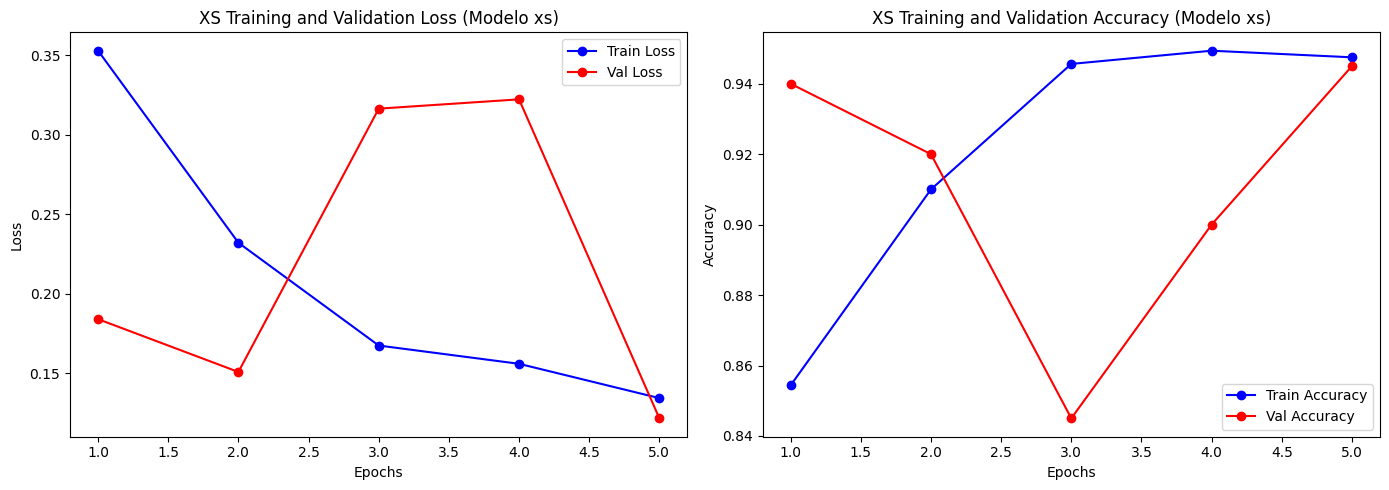

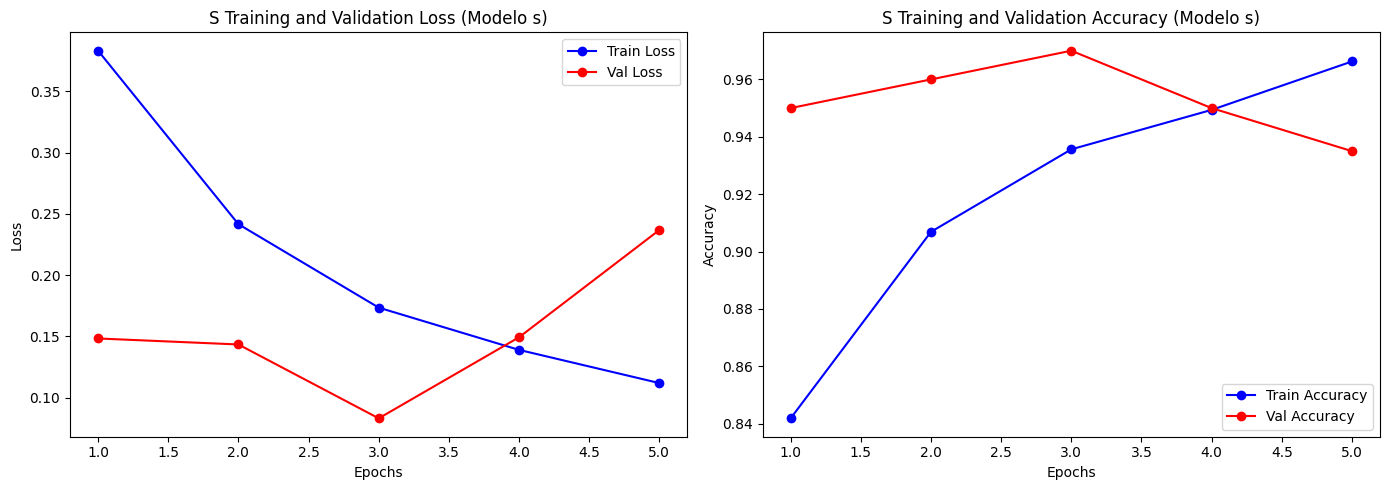

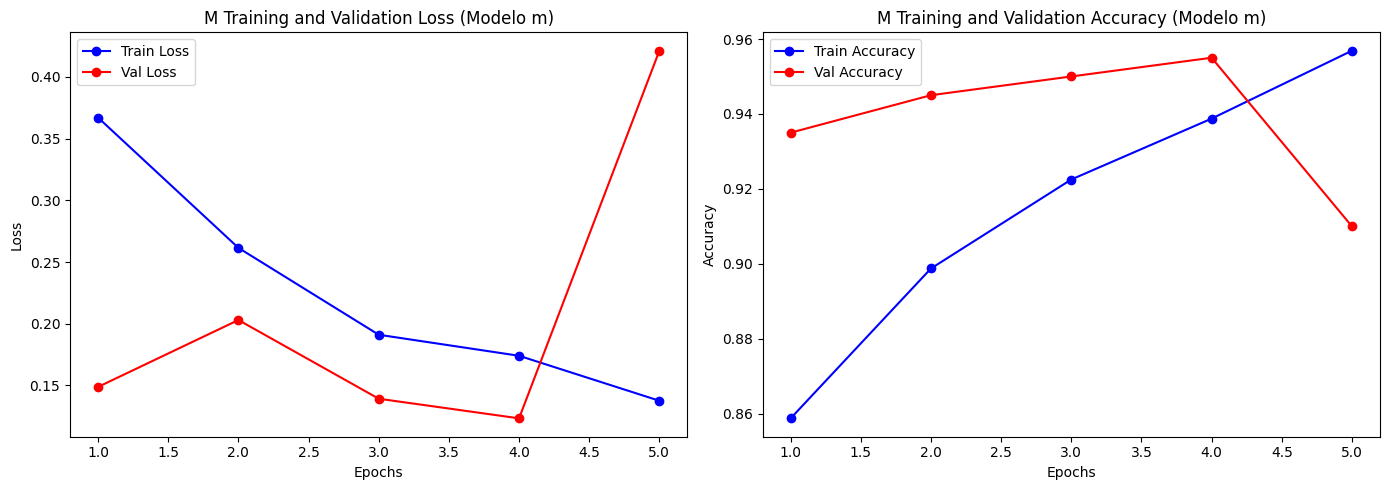

In [33]:
# Crear un gráfico para cada modelo
for key in metrics:
    # Definir rango de épocas
    epochs = range(1, NUM_EPOCHS + 1)

    # Configurar la figura para pérdidas y precisión
    plt.figure(figsize=(14, 5))

    # -- Gráfico de pérdidas de entrenamiento y validación --
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics[key]["train_losses"], 'bo-', label='Train Loss')
    plt.plot(epochs, metrics[key]["val_losses"], 'ro-', label='Val Loss')
    plt.title(f'{key.upper()} Training and Validation Loss (Modelo {key})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # -- Gráfico de precisión de entrenamiento y validación --
    plt.subplot(1, 2, 2)  # Segunda posición en una figura de 1x2
    plt.plot(epochs, metrics[key]["train_accuracies"], 'bo-', label='Train Accuracy')
    plt.plot(epochs, metrics[key]["val_accuracies"], 'ro-', label='Val Accuracy')
    plt.title(f'{key.upper()} Training and Validation Accuracy (Modelo {key})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

Se define una función que grafica una matriz de confusión para un modelo. En este caso, permite graficar la matriz de confusión para los mejores modelos xs, s y m.

In [34]:
# Calcular y graficar la matriz de confusión para un modelo
def plot_confusion_matrix(model, loader, classes, device, model_name):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(classes)))

    # Graficar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión para {model_name}")
    plt.show()

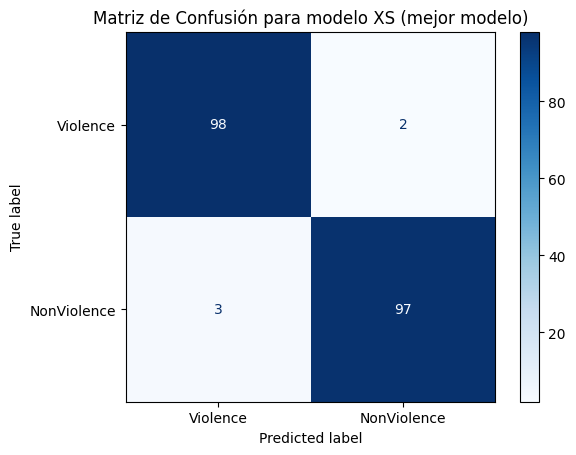

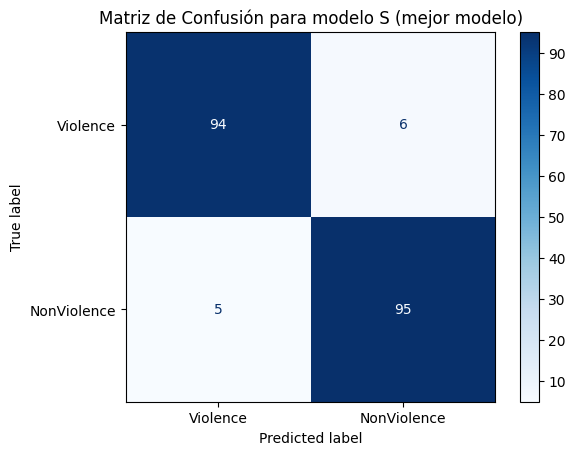

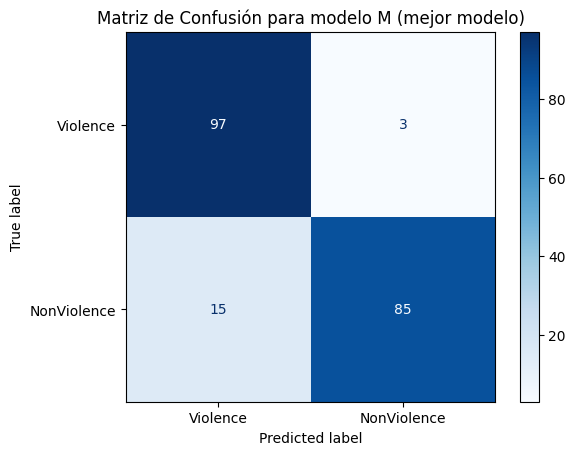

In [36]:
plot_confusion_matrix(metrics["xs"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo XS (mejor modelo)")
plot_confusion_matrix(metrics["s"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo S (mejor modelo)")
plot_confusion_matrix(metrics["m"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo M (mejor modelo)")

Ahora, se evalúa el desempeño de los modelos entrenados utilizando el conjunto de prueba. Para ello, se genera un reporte detallado que incluye las siguientes métricas clave para cada clase:

- **Precisión (Precision):** La proporción de instancias correctamente clasificadas de una clase respecto al total de predicciones para esa clase.
- **Sensibilidad (Recall):** También conocida como "Tasa de Verdaderos Positivos", mide qué tan bien el modelo identifica correctamente las instancias de una clase.
- **F1-Score:** Promedio armónico de precisión y recall, que equilibra estas métricas, especialmente útil en conjuntos de datos desbalanceados.

Para cada modelo (XS, S y M), mostramos estas métricas junto con el número total de instancias evaluadas por clase. Este reporte es esencial para entender el desempeño detallado del modelo y comparar su efectividad en la clasificación entre las distintas clases.

In [38]:
# Genera y muestra un informe con precisión, recall y F1-Score para cada clase
def print_classification_report(model, loader, classes, device, model_name):
    model.eval()
    all_labels = []
    all_predictions = []

    # Desactivar el cálculo del gradiente durante la evaluación
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Realizar predicciones con el modelo
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Mostrar el reporte de clasificación
    print(f'----- Reporte de clasificación para {model_name} -----\n')
    report = classification_report(all_labels, all_predictions, target_names=classes)
    print(report)

# Llamar a la función después de evaluar el modelo
print_classification_report(metrics["xs"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo XS (mejor modelo)")
print_classification_report(metrics["s"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo S (mejor modelo)")
print_classification_report(metrics["m"]["best_model"], test_loader, CLASS_NAMES, DEVICE, model_name="modelo M (mejor modelo)")

----- Reporte de clasificación para modelo XS (mejor modelo) -----

              precision    recall  f1-score   support

    Violence       0.97      0.98      0.98       100
 NonViolence       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

----- Reporte de clasificación para modelo S (mejor modelo) -----

              precision    recall  f1-score   support

    Violence       0.95      0.94      0.94       100
 NonViolence       0.94      0.95      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

----- Reporte de clasificación para modelo M (mejor modelo) -----

              precision    recall  f1-score   support

    Violence       0.87      0.97      0.92       100
 NonViolence       0.97      0.85  

Se complementa la evaluación del desempeño, definiendo una función que genera las curvas ROC (Receiver Operating Characteristic) y el AUC (Área bajo la curva). La curva ROC y el AUC proporcionan una medida intuitiva y visual de qué tan bien se desempeñan los modelos al clasificar instancias entre las clases positivas y negativas.

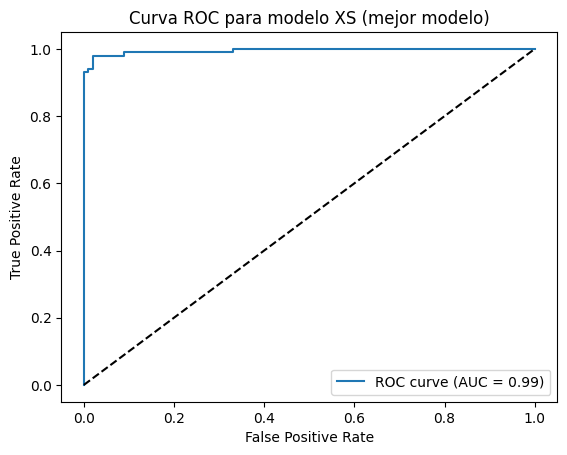

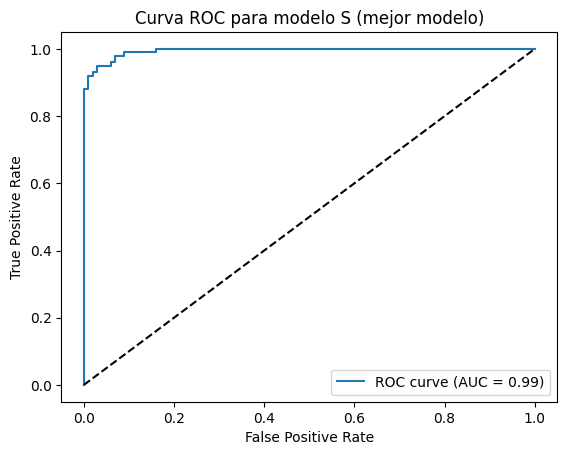

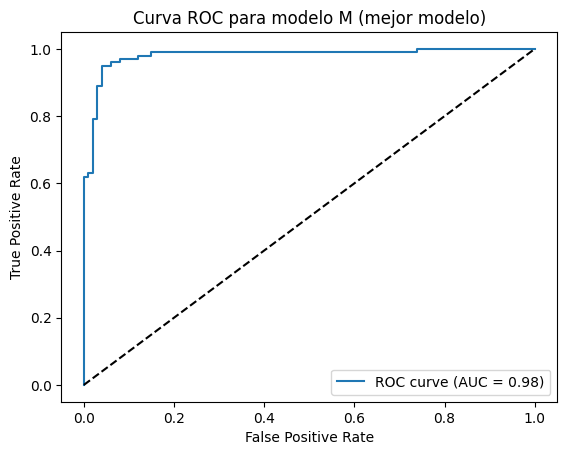

In [39]:
# Genera una curva ROC y calcula el AUC para un modelo
def plot_roc_curve(model, loader, device, model_name):
    model.eval()
    all_labels = []
    all_probs = []

    # Desactivar el cálculo del gradiente para mejorar el rendimiento
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Realizar predicciones con el modelo
            outputs = model(inputs)

            # Aplicar softmax para obtener probabilidades
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calcular las métricas de la curva ROC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (aleatorio)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC para {model_name}')  # Título con el nombre del modelo
    plt.legend(loc="lower right")
    plt.show()

# Llamar a la función después de evaluar el modelo
plot_roc_curve(metrics["xs"]["best_model"], test_loader, DEVICE, model_name="modelo XS (mejor modelo)")
plot_roc_curve(metrics["s"]["best_model"], test_loader, DEVICE, model_name="modelo S (mejor modelo)")
plot_roc_curve(metrics["m"]["best_model"], test_loader, DEVICE, model_name="modelo M (mejor modelo)")